# Grover's Algorithm

&nbsp;

### Contents

1. [Grover's Algorithm](#ga)
2. [Grover's Algorithm - Exactly-1 3-SAT problem](#ga1)

## 1. Grover's Algorithm <a id ='ga'></a>

In 1996, Lov Grover preseted its fast algorithm for a database search problem.   This  algorithm  can  also  serve  as  a  general  trick  or  subroutine  to  obtain quadratic runtime enhancements in other algorithms.

Let’s consider a list with $0$ to $N$ items. In this list,  there is a particular object, $w$,  that we want to localize.

|$0$|$0$|$0$||$1$||$0$|$0$|
|-|-|-|-|-|-|-|-|
|$0$|$1$|$2$|...|$w$|...|$N-1$|$N=2^n$|

In a classical computer, the worst case scenario forces us to test all the  $N$  items before finding the wanted one, and on average we need to test  $N/2$  items. Quantum computing shows a real advantage by finding the targeted object in $\sqrt{N}$ steps. Additionally, this algorithm is also **generic** because it does not use the internal structure of the list.

Similarly to what happened in the Deutsh-Jozsa algorithm, in Grover’s algorithm we also need an Oracle. A simple way to encode the oracle function is:

$$f(x)=0$$
$$f(w)=1$$

<img src="https://scx2.b-cdn.net/gfx/news/2018/groversearch.jpg" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="800 px" align="center">

The three stages of the 3-qubit Grover search algorithm: initialization, oracle, and amplification. Credit: C. Figgatt et al. Published in Nature Communications

In [1]:
# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, transpile

from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_state_hinton

import matplotlib.pyplot as plt
%matplotlib inline

*Let's start with an example: Grover's algorithm with $N=4$.*

In [2]:
n = 2
grover_circuit = QuantumCircuit(n,n)

**1**  Initialize the system with the same amplitude in all possible input states.

$$ \frac{1}{2} (|00\rangle+ |01\rangle+|10\rangle+|11\rangle) $$

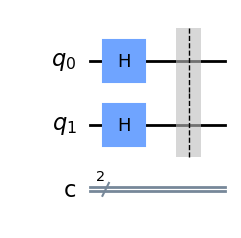

In [3]:
for q in range(n):
    grover_circuit.h(q)

grover_circuit.barrier()

grover_circuit.draw(output='mpl')

**2** Despite the algorithm applying $\sqrt{N}$ times the following unitary operations, in this case only **one** is necessary:

**a)** Quantum Oracle operator $U_w$. This operator is responsible for identifying the solutions to the problem and indicating the target.

$$-\alpha_m \lvert x_m \rangle + \beta \sum_{x_i \neq x_m}\lvert x_i \rangle$$ 

With this implementation, the phase of the marked state ($f(x_m) = 1$) rotates $\pi$ radians, while the others states keep the system unchanged.

$$U_w|s\rangle = U_w \frac{1}{2} (|00\rangle+ |01\rangle+|10\rangle+|11\rangle) = \frac{1}{2} (|00\rangle+ |01\rangle+|10\rangle-|11\rangle)$$

<div class="alert alert-block alert-info">
    
This type of oracle is sometimes called a **Phase Oracle**. 
    
It would be possible to implement it with a **Boolean Oracle**. The Boolean oracle uses an ancilla qubit. We will see how they work in the second example. 

</div>

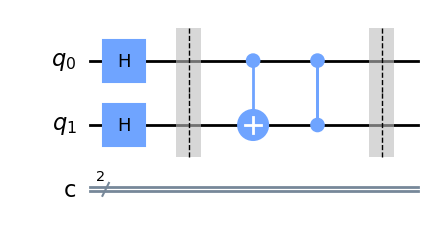

In [4]:
# If both qubits are in the states |0> than phase flip the state

grover_circuit.cx(0,1)
grover_circuit.cz(0,1) # End of oracle
grover_circuit.barrier()

grover_circuit.draw(output='mpl')

**b)** Apply the diffusion transform $U_D$. 

$$ 2 |s\rangle \langle s| - Id$$

This operator implementation can be achieved by $U_D=WRW$, where $W$ is the Walsh-Hadamard transform matrix, and $R$ is a rotation matrix.

$$(2A + \alpha_m)\lvert x_m \rangle + (2A-\beta)\sum_{x_i\neq x_m} \lvert x_i \rangle $$

This step of the algorithm does not only flips the desired input but also increases its amplitude.

In other words, $$ H^{\otimes n} (2 |0\rangle \langle 0|-I) H ^{\otimes n}$$

First, we add an Hadamard gate to each qubit  to transform $|s\rangle \rightarrow |0\rangle$. 

$$\frac{1}{2} (|00\rangle+ |01\rangle+|10\rangle+|11\rangle)$$

Then we apply $U_0 = 2 |0\rangle \langle 0|-I $ to flip the sign of the states that are perpendicular $|00\rangle$. 

For instance, add an X gate in each qubit:
$$\frac{1}{2} (|00\rangle+ |01\rangle+|10\rangle+|11\rangle)$$
a CZ gate:
$$\frac{1}{2} (|00\rangle+ |01\rangle+|10\rangle-|11\rangle)$$
and again, an X gate to each qubit:
$$\frac{1}{2} (-|00\rangle+ |01\rangle+|10\rangle+|11\rangle)$$

<div class="alert alert-block alert-warning">
    
Note that we have applied a negative phase to all the states that are *parallel* to $|s\rangle$, not *perpendicular* as we specified. 
    
**Why does this work?**
</div>

Finally, we add an Hadamard gate to each qubit again to transform $|0\rangle \rightarrow |s\rangle$.

$$\frac{1}{2} (|00\rangle- |01\rangle-|10\rangle-|11\rangle)$$


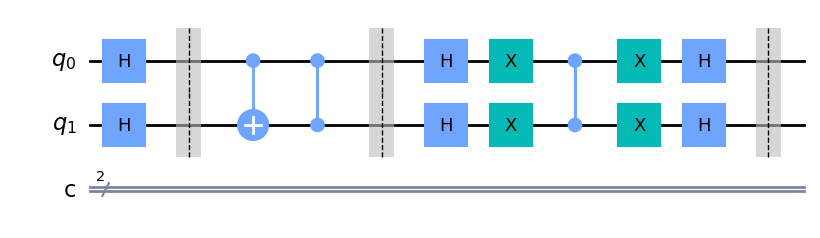

In [5]:
for q in range(n):
    grover_circuit.h(q)
    
for q in range(n):
    grover_circuit.x(q)
    
grover_circuit.cz(0,1)
    
for q in range(n):
    grover_circuit.x(q)
    
for q in range(n):
    grover_circuit.h(q)

grover_circuit.barrier()

grover_circuit.draw(output='mpl')

**3** Measure the qubits.

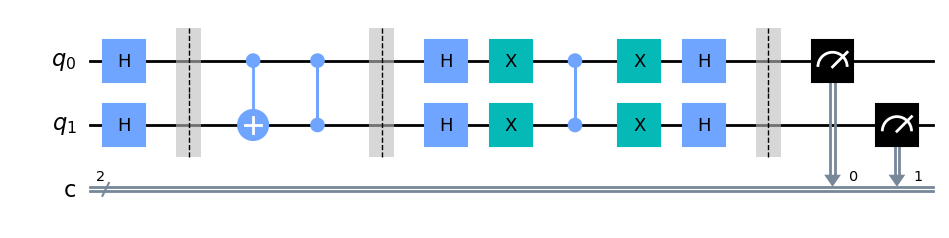

In [6]:
for q in range(n):
    grover_circuit.measure(q,q)
    
grover_circuit.draw(output='mpl')

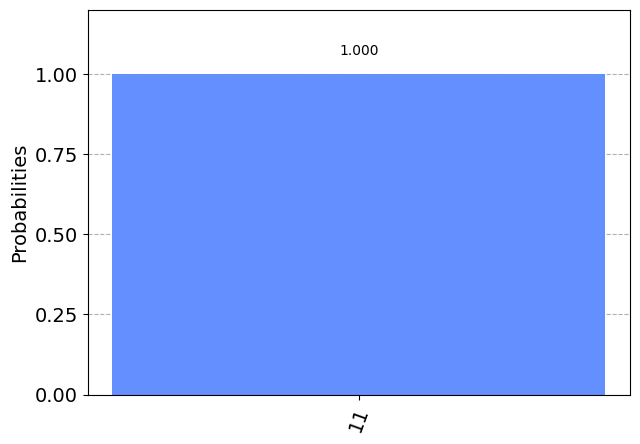

In [7]:
backend_sim = Aer.get_backend('aer_simulator')

job_sim = execute(grover_circuit, backend_sim)
result_sim = job_sim.result()
result_counts = result_sim.get_counts(grover_circuit)

plot_histogram(result_counts)

## 2. Grover's Algorithm - Exactly-1 3-SAT problem <a id='ga1'></a>

Here, we are going to illustrate the use of Grover search to solve a combinatorial problem called Exactly-1 3-SAT problem. The Exactly-1 3-SAT problem is a NP-complete problem, namely, it is one of the most difficult problems that are interconnected (meaning that if we solve any one of them, we essentially can solve all of them). Unfortunately, there are many natural problems that are NP-complete, such as, the Traveling Salesman Problem (TSP), the Maximum Cut (MaxCut) and so on. Up to now, there is no classical and quantum algorithm that can efficiently solve such NP-hard problems. 

### Exactly-1 3-SAT problem

The Exactly-1 3-SAT problem is best explained with the following concrete problem. Let us consider a Boolean function $f$ with three Boolean variables $x_1, x_2, x_3$ as below.

$$
f(x_1, x_2, x_3) = (x_1 \vee x_2 \vee \neg x_3) \wedge (\neg x_1 \vee \neg x_2 \vee \neg x_3) \wedge (\neg x_1 \vee x_2 \vee x_3) 
$$

In the above function, the terms on the right-hand side equation which are inside $()$ are called clauses. Each clause has exactly three literals. Namely, the first clause has $x_1$, $x_2$ and $\neg x_3$ as its literals. The symbol $\neg$ is the Boolean NOT that negates (or, flips) the value of its succeeding literal. The symbols $\vee$ and $\wedge$ are, respectively, the Boolean OR and AND. The Boolean $f$ is satisfiable if there is an assignment of $x_1, x_2, x_3$ that evaluates to $f(x_1, x_2, x_3) = 1$ (or, $f$ evaluates to True). The Exactly-1 3-SAT problem requires us to find an assignment such that $f = 1$ (or, True) and there is *exactly* one literal that evaluates to True in every clause of $f$. 

A naive way to find such an assignment is by trying every possible combinations of input values of $f$. Below is the table obtained from trying all possible combinations of $x_1, x_2, x_3$. For ease of explanation, we interchangably use $0$ and False, as well as $1$ and True.  

|x_1 | x_2 | x_3 | f | Comment | 
|------|-------|-------|-----|---------|
| 0    |  0    |  0    |  1  | Not a solution because there are three True literals in the second clause     | 
| 0    |  0    |  1    |  0  | Not a solution because $f$ is False          | 
| 0    |  1    |  0    |  1  | Not a solution because there are two True literals in the first clause        | 
| 0    |  1    |  1    |  1  | Not a solution because there are three True literals in the third clause        | 
| 1    |  0    |  0    |  0  | Not a solution because $f$ is False        | 
| 1    |  0    |  1    |  1  | **Solution**. BINGO!!       | 
| 1    |  1    |  0    |  1  | Not a solution because there are three True literals in the first clause        | 
| 1    |  1    |  1    |  0  | Not a solution because $f$ is False        | 


From the table above, we can see that the assignment $x_1x_2x_3 = 101$ is the solution for the Exactly-1 3-SAT problem to $f$. In general, the Boolean function $f$ can have many clauses and more Boolean variables. 


In [8]:
# Plot results
def show_results(D):
    # D is a dictionary with classical bits as keys and count as value
    # example: D = {'000': 497, '001': 527}
    plt.bar(range(len(D)), list(D.values()), align='center')
    plt.xticks(range(len(D)), list(D.keys()))
    plt.show()

# Execute circuit, display a histogram of the results
def execute_locally(qc, draw_circuit=False):
    # Compile and run the Quantum circuit on a simulator backend
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(qc, backend_sim)
    result_sim = job_sim.result()
    result_counts = result_sim.get_counts(qc)
    
    # Print the results
    print("simulation: \n\n", result_counts)
    show_results(result_counts)

<div class="alert alert-block alert-warning">

**Exercise 3.1 - State Initialization**

Begin by implementing a function for state initialization, i.e. implementing the circuit below for an arbitrary number of qubits.

<img src="img/init.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="400 px" align="center"> 

</div>

In [9]:
# Inputs: QuantumCircuit circuit, input register f_in, output register f_out
def input_state(circuit, f_in, f_out):
    circuit.x(f_out)
    circuit.h(f_out)
    circuit.h(f_in)

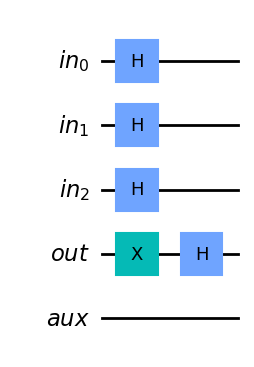

In [10]:
f_in = QuantumRegister(3, "in")
f_out = QuantumRegister(1, "out")
aux = QuantumRegister(1, "aux")
qc = QuantumCircuit(f_in, f_out, aux)

input_state(qc, f_in, f_out)
qc.draw(output='mpl')

### A blackbox function to check the assignment of Exactly-1 3-SAT problem

Here, we describe a method to construct a circuit to check the assignment of Exactly-1 3-SAT problem. The circuit can then be used as a blackbox (or, oracle) in Grover search. To design the blackbox, we do not need to know the solution to the problem in advance: it suffices to design a blackbox that checks if the assignment results in $f$ evaluates to True or False. It turns out that we can design such a blackbox efficiently (in fact, any NP-complete problem has the property that although finding the solution is difficult, checking the solution is easy). 

For each clause of $f$, we design a sub-circuit that outputs True if and only if there is exactly one True literal in the clause. Combining all sub-circuits for all clauses, we can then obtain the blackbox that outputs True if and only if all clauses are satisfied with exactly one True literal each.   

For example, let us consider the clause $(x_1 \vee \neg x_2 \vee x_3)$. It is easy to see that $y$ defined as 

$$
y = x_1 \oplus \neg x_2 \oplus x_3 \oplus ( x_1 \wedge \neg x_2 \wedge x_3), 
$$

Note that this clause can be written as [1, -2, 3]

is True if and only if exactly one of $x_1$, $\neg x_2$, and $x_3$ is True. Using two working qubits, $y$ can be computed by the following sub-circuit. Below, $x_1x_2x_3$ is renamed as $q_1q_2q_3$, $q_4$ is used as a working qubit, and $q_5$ is used to store the value of $y$.  

<div class="alert alert-block alert-warning">

**Exercise 3.2 - Blackbox**

1. Implement the circuit below, for the blackbox:

<img src="img/black_box1.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="400 px" align="center"> 

Keep in mind that a CCNOT can be decomposed using an ancilla qubit (q4):

<img src="img/cccnot.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="300 px" align="center"> 

2. Compare the circuit outputs with the clausule $(x_1 \vee \neg x_2 \vee x_3)$. How can we generalize the circuit for any Exactly-1 3-SAT clausule? Implement such a routine in the function `sub_oracle` below.

3. Implement a function `blackbox_u_f` that calls `sub_oracle` as many times as there are clausules in the formula.

</div>

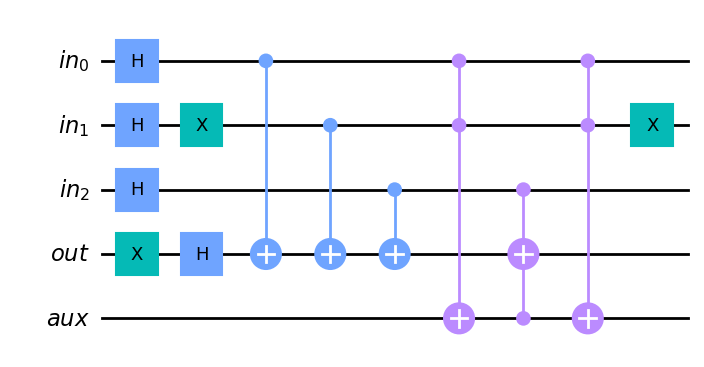

In [11]:
# 1.
qc.x(f_in[1])
for i in range(len(f_in)):
    qc.cx(f_in[i], f_out[0])
qc.ccx(f_in[0], f_in[1], aux[0])
qc.ccx(f_in[2], aux[0], f_out[0])
qc.ccx(f_in[0], f_in[1], aux[0])
qc.x(f_in[1])
qc.draw(output='mpl')


In [12]:
# 2. Inputs: ancilliary qubit aux, and clausule, as a list of 3 integers  
def sub_oracle(circuit: QuantumCircuit, f_in: QuantumRegister, f_outx: QuantumRegister, aux: QuantumRegister, clausule: list):
    is_ = []
    # 1. Apply X gates to the input qubits that are 1 in the clausule
    for i, val in enumerate(clausule):
        if val < 0:
            is_.append(i)
            circuit.x(f_in[i])
    # 2. Sum Mod 2 all the input qubits
    for i in range(len(f_in)):
        circuit.cx(f_in[i], f_outx)
    qc.ccx(f_in[0], f_in[1], aux[0])
    qc.ccx(f_in[2], aux[0], f_outx)
    qc.ccx(f_in[0], f_in[1], aux[0])
    for i in is_:
        circuit.x(f_in[i])

<div class="alert alert-block alert-warning">

We can check if the subroutine works as intended by printing the circuit for a clause:

</div>

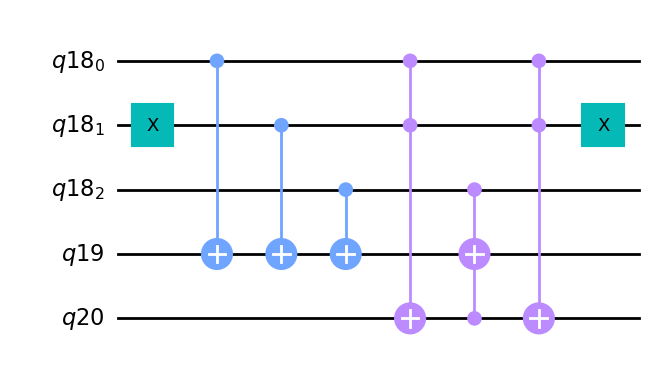

In [13]:
f_in = QuantumRegister(3)
f_out = QuantumRegister(1)
aux = QuantumRegister(1)
qc = QuantumCircuit(f_in, f_out, aux)
clausula = [1,-2,3]

sub_oracle(qc, f_in, f_out, aux, clausula)

qc.draw(output='mpl')

In [14]:
# 3.
def black_box_u_f(circuit: QuantumCircuit, f_in: QuantumRegister, f_out: QuantumRegister, aux: QuantumRegister, sat_formula: list):
        
    # loop to ensure aux is 1 if an odd number of literals are true
    for n, clausule in enumerate(sat_formula):
        sub_oracle(circuit, f_in, f_out[n], aux, clausule)
        circuit.barrier()

    # flip fout[3] if all literals are true
    circuit.ccx(f_out[0], f_out[1], aux)
    circuit.ccx(f_out[2], aux, f_out[3])
    circuit.ccx(f_out[0], f_out[1], aux)
    circuit.barrier()
    # loop to reverse the state of negative literals and ancilla
    for n, clausule in enumerate(sat_formula):
        sub_oracle(circuit, f_in, f_out[n], aux, clausule)
        circuit.barrier()

<div class="alert alert-block alert-warning">

We can check that the oracle works, for the formula above (f should return 1 for x<sub>1</sub> = 1, x<sub>2</sub> = 0, x<sub>3</sub> = 1).

</div>

In [15]:
sat_formula = [[1,2,-3],[-1,-2,-3],[-1,2,3]]

#3 input qubits (3 literals in each clause)
f_in = QuantumRegister(3, "in")
#1 ancilla qubit (ccx decomposition)
aux = QuantumRegister(1, "aux")
#output qubits = number of clauses + 1 (final output)
f_out = QuantumRegister(4, "out")
print(*f_out)

# Create circuit
qc = QuantumCircuit(f_in, aux, f_out)

# Prepare input states, x1=1, x3=1
qc.x(f_in[0])
# qc.h(f_in[1])
qc.x(f_in[2])

black_box_u_f(qc, f_in, f_out, aux, sat_formula)

print(*f_out)
cr = ClassicalRegister(7)
qc.add_register(cr)

qc.measure(f_in[0], cr[0])
qc.measure(f_in[1], cr[1])
qc.measure(f_in[2], cr[2])

print(*f_out)
qc.measure(f_out[0], cr[3])
qc.measure(f_out[1], cr[4])
qc.measure(f_out[2], cr[5])
qc.measure(f_out[3], cr[6])

Qubit(QuantumRegister(4, 'out'), 0) Qubit(QuantumRegister(4, 'out'), 1) Qubit(QuantumRegister(4, 'out'), 2) Qubit(QuantumRegister(4, 'out'), 3)
Qubit(QuantumRegister(4, 'out'), 0) Qubit(QuantumRegister(4, 'out'), 1) Qubit(QuantumRegister(4, 'out'), 2) Qubit(QuantumRegister(4, 'out'), 3)
Qubit(QuantumRegister(4, 'out'), 0) Qubit(QuantumRegister(4, 'out'), 1) Qubit(QuantumRegister(4, 'out'), 2) Qubit(QuantumRegister(4, 'out'), 3)


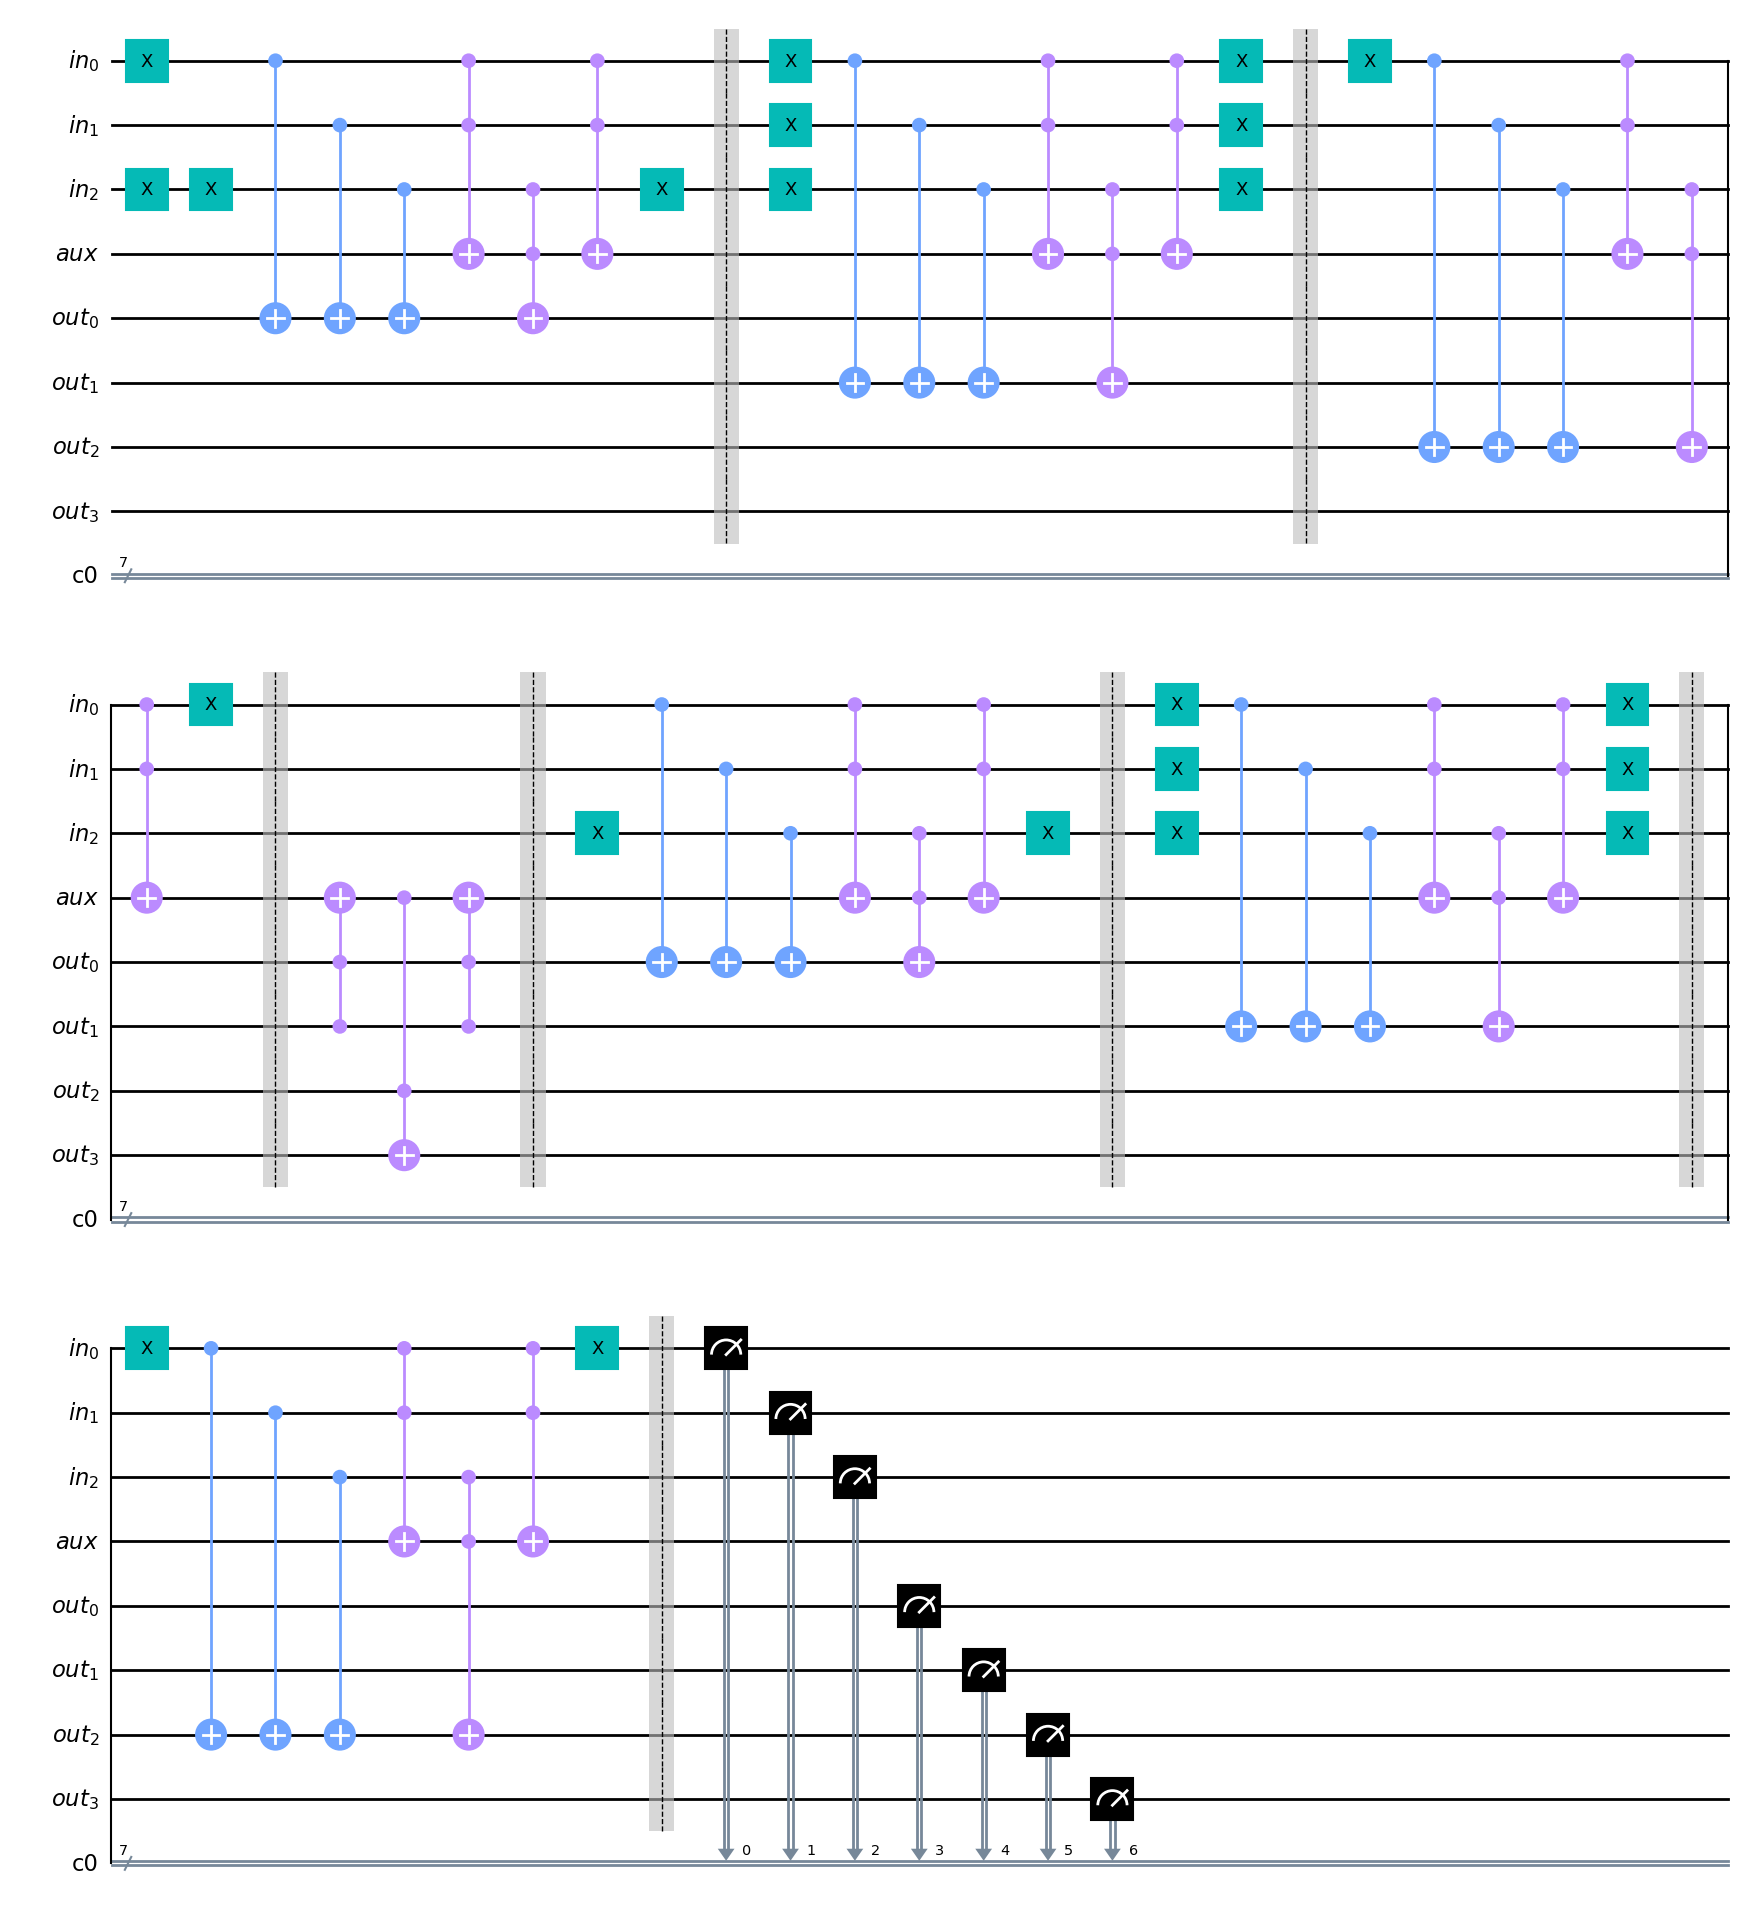

In [16]:
qc.draw(output='mpl')

simulation: 

 {'1000101': 1024}


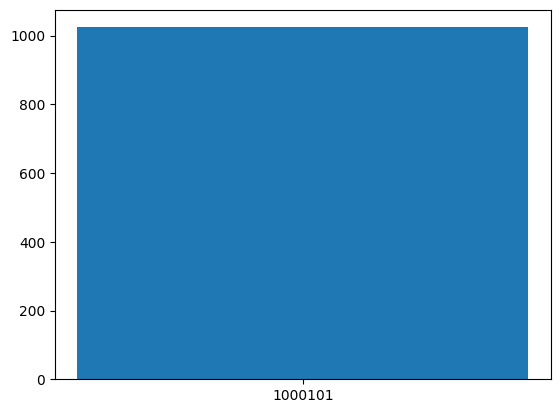

In [17]:
execute_locally(qc)

<div class="alert alert-block alert-info">

**Inversion about the mean**

In this step, we apply

&nbsp;

$$
H^{\otimes n} \left(2|0\rangle \langle 0 | - I \right) H^{\otimes n}
$$

&nbsp;

The function `inversion_about_mean` makes use of a $C^nZ$ gate, which is equivalent to a $C^nNOT$ gate with the target qubit encapsulated between Hadamard gates.

</div>

In [18]:
# 3-Sat: at most 3 literals in each clause
def inversion_about_mean(circuit, f_in):
    n = f_in.__len__()
    
    circuit.h(f_in)
    circuit.x(f_in)
    
    circuit.h(f_in[n-1])
    
    if n == 2:
        circuit.cx(f_in[0], f_in[1])
    
    elif n == 3:
        circuit.ccx(f_in[0], f_in[1], f_in[2])
        
    circuit.h(f_in[n-1])
        
    circuit.x(f_in)
    circuit.h(f_in)

<div class="alert alert-block alert-warning">

Here is a circuit of the inversion about the mean on three qubits.

</div>

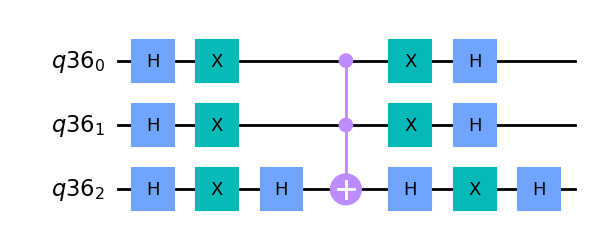

In [19]:
qr = QuantumRegister(3)
qInvAvg = QuantumCircuit(qr)

inversion_about_mean(qInvAvg, qr)

qInvAvg.draw(output='mpl')

<div class="alert alert-block alert-warning">

**Exercise 4.1 - Putting it all together**

&nbsp;

<img src="https://qiskit.org/textbook/ch-algorithms/images/grover_circuit_high_level.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="600 px" align="center"> 

&nbsp;

The complete steps of Grover search are as follows.

1. Create the superposition of all possible solutions as the initial state (with working qubits initialized to zero)

$$  \sum_{j=0}^{2^{n}-1} \frac{1}{2^n} |j\rangle |0\rangle$$

2. Repeat for $T = \sqrt{N}$ times:

     * Apply the `blackbox` function
    
     * Apply the `inversion-about-the-mean` function
    
3. Measure `f_in` to obtain the solution

Note: $N = 2^n$, where $n$ is the number of qubits in `f_in`.

</div>

In [20]:
from math import sqrt
def grover_3sat(sat_formula):
    # Number of clauses 
    n=3
    # 3 literals - 3 qubits
    f_in = QuantumRegister(3, "in")
    # Number of iterations: sqrt(2^3) - 2 iterations
    i = 2
    # Number of qubits in f_out: number of clauses + 1
    f_out = QuantumRegister(n+1, "out")
    # Ancilla qubit
    aux = QuantumRegister(1, "aux")
    # Measure f_in at the end to a classical register
    cr = ClassicalRegister(3)
    # Create Circuit
    qc = QuantumCircuit(f_in, aux, f_out, cr)
    # Initialize
    input_state(qc, f_in, f_out[n])
    # Iterate blackbox and inversion
    for k in range(i):
        black_box_u_f(qc, f_in, f_out, aux, sat_formula)
        inversion_about_mean(qc, f_in)

    qc.measure(f_in, cr)
    execute_locally(qc)

simulation: 

 {'101': 124, '110': 112, '100': 130, '001': 117, '000': 151, '010': 130, '011': 119, '111': 141}


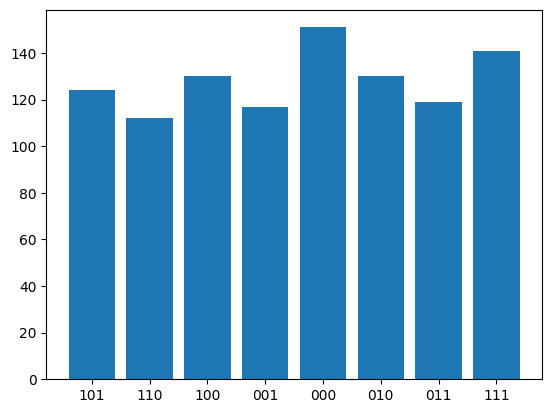

In [21]:
sat_formula = [[1, 2, -3], [-1, -2, -3], [-1, 2, 3]]
grover_3sat(sat_formula)

**Refs:**

* [An Introduction to Quantum Computing, Without the Physic](https://arxiv.org/pdf/1708.03684.pdf)
* [Qiskit](https://qiskit.org/textbook/ch-algorithms/grover.html)
* [Complete 3-Qubit Grover search on a programmable quantum computer](https://www.nature.com/articles/s41467-017-01904-7)
* [Grover's Algorithm](https://cnot.io/quantum_algorithms/grover/grovers_algorithm.html)